In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
path = 'kilt/'
finetune = pd.read_csv(path + "edit_success_20210527.10.05.1622137956_bart-base_epoch1_ts10000.2021-05-26_10-47-02-543657yWNwE")
# ewc = 
mmtm = pd.read_csv(path + "edit_success_mmtm0.0005_20210527.11.05.1622139458_bart-base_epoch1_ts10000.2021-05-26_10-47-02-543657yWNwE")
enn1a = pd.read_csv(path + "edit_success_20210526.09.05.1622046619_bart-base_cloze_kilt_epoch1_ts50000.2021-05-25_15-20-18-028618TOXsl")
enn1b = pd.read_csv(path + "edit_success_20210526.09.05.1622046277_bart-base_cloze_kilt_epoch1_ts50000.2021-05-25_15-19-14-450259hVHDP")
senn1a = pd.read_csv(path + "edit_success_20210526.09.05.1622046603_bart-base_cloze_kilt_split_epoch1_ts50000.2021-05-25_15-27-49-689252cVAKQ")
senn5a = pd.read_csv(path + "edit_success_20210525.18.05.1621992562_bart-base_cloze_kilt_split_epoch1_ts9999.2021-05-24_18-36-22-263362")
senn3c = pd.read_csv(path + "edit_success_20210525.18.05.1621994166_bart-base_cloze_kilt_split_epoch1_ts9999.2021-05-24_18-43-50-378443")
senn3a = pd.read_csv(path + "edit_success_20210525.18.05.1621994186_bart-base_cloze_kilt_split_epoch1_ts9999.2021-05-24_18-34-54-989178")
senn3b = pd.read_csv(path + "edit_success_20210525.18.05.1621994101_bart-base_cloze_kilt_split_epoch1_ts9999.2021-05-24_18-36-22-903957")
senn10 = pd.read_csv(path + "edit_success_20210527.08.05.1622130892_bart-base_cloze_kilt_split_epoch0_ts20000.2021-05-26_13-05-37-032000wiyGT")

In [8]:
mmtm

,model_number,edit_number,train_step,n_edit_steps,edit_step,logits,orig_ppl,new_ppl,orig_acc,new_acc,orig_lp,new_lp,norm,edit_accuracy,grouping
0,0,0,0,10,0,-3.034061,25.357141,NaN,0.59,0.515,-0.506391,-0.643727,3.505255,0.0,0
1,0,0,0,10,1,-0.008427,25.357141,NaN,0.59,0.515,-0.506391,-0.643727,3.505255,1.0,0
2,0,0,0,10,2,-0.000015,25.357141,NaN,0.59,0.515,-0.506391,-0.643727,3.505255,1.0,0
3,0,0,0,10,3,-0.000010,25.357141,NaN,0.59,0.515,-0.506391,-0.643727,3.505255,1.0,0
4,0,0,0,10,4,-0.000009,25.357141,NaN,0.59,0.515,-0.506391,-0.643727,3.505255,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,4,99,499,10,6,-0.046235,25.357141,NaN,0.59,0.015,-0.506391,-2.572208,32.598358,1.0,90
5496,4,99,499,10,7,-0.028722,25.357141,NaN,0.59,0.015,-0.506391,-2.572208,32.598358,1.0,90
5497,4,99,499,10,8,-0.020992,25.357141,NaN,0.59,0.015,-0.506391,-2.572208,32.598358,1.0,90
5498,4,99,499,10,9,-0.016548,25.357141,NaN,0.59,0.015,-0.506391,-2.572208,32.598358,1.0,90


In [3]:
data = [
    {"data": finetune, "opts": { "label": "BART", "color": "black", "linewidth": 3} },
#     {"data": enn1a, "opts": { "label": "ENN-1 0.1/1", "color": "black", "linewidth": 3} },
    {"data": enn1b, "opts": { "label": "ENN-1 0.01/1", "color": "gray", "linewidth": 3} },
#     {"data": senn1a, "opts": { "label": "SENN-1 0.1/1", "color": "pink", "linewidth": 3} },
    {"data": senn3a, "opts": { "label": "PGP-3 0.1/10", "color": "blue", "linewidth": 3} },
    {"data": senn5a, "opts": { "label": "PGP-5 0.1/10", "color": "yellow", "linewidth": 3} },
#     {"data": senn3b, "opts": { "label": "SENN-3 1/10", "color": "orange", "linewidth": 3} },
#     {"data": senn3c, "opts": { "label": "SENN-3 1/3", "color": "red", "linewidth": 3} },
    {"data": senn10, "opts": { "label": "PGP-10 0.1/10 @ 20k", "color": "red", "linewidth": 3} },
    {"data": mmtm, "opts": {"label": "MMTM 5e-4", "color": "green", "linewidth": 3} }
]


In [28]:
spacing = 10
spacing_function = lambda x: (int(x /spacing) + 1) * spacing
n_vis = 100

for d in data:
    d["data"]['grouping'] = d["data"].edit_number.apply(spacing_function)

In [29]:
# Plot config
# print(matplotlib.rcParams.keys())
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["legend.fontsize"] = 14

In [30]:
use_relative_drawdown = False

In [33]:
filter_query = f'edit_step == {d["data"].edit_step.max()} and edit_number < {n_vis} and (edit_number % 10 == 9 or edit_number == 0)'
d["data"].query(filter_query).groupby("edit_number").logits.apply(mean_exp)

edit_number
0     0.989016
9     0.998031
19    0.997717
29    0.995178
39    0.991352
49    0.995527
59    0.988394
69    0.979848
79    0.992055
89    0.991829
99    0.996181
Name: logits, dtype: float64

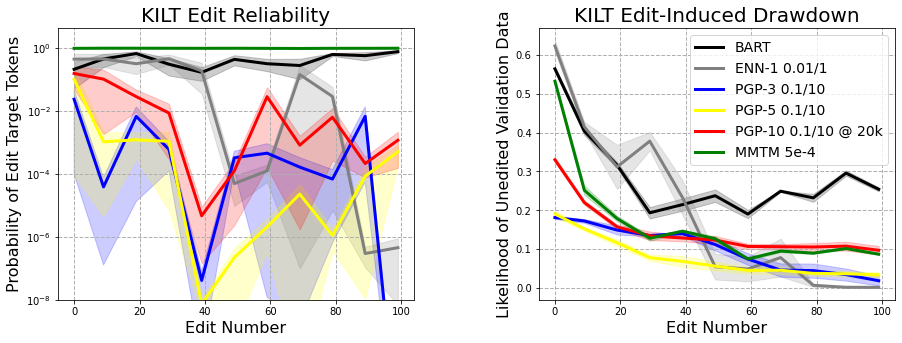

In [35]:
mean_exp = lambda x: np.mean(np.exp(x))
sem_exp = lambda x: np.exp(x).std() / x.shape[0]**0.5

def edit_metrics(frame):
    filter_query = f'edit_step == {frame.edit_step.max()} and edit_number < {n_vis} and (edit_number % 10 == 9 or edit_number == 0)'
    return (
        frame.query(filter_query).groupby("edit_number").logits.apply(mean_exp),
        frame.query(filter_query).groupby("edit_number").logits.apply(sem_exp)
    )

def drawdown_metrics(frame):
    return (
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").new_lp.apply(mean_exp),
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").new_lp.apply(sem_exp)
    )

def relative_drawdown(frame):
    mean_metric = lambda x: np.mean((np.exp(x.orig_lp) - np.exp(x.new_lp)) / np.exp(x.orig_lp))
    std_metric = lambda x: np.std((np.exp(x.orig_lp) - np.exp(x.new_lp)) / np.exp(x.orig_lp)) / x.shape[0]**0.5
    return (
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").apply(mean_metric),
        frame.loc[~frame.new_lp.isna()].groupby("edit_number").apply(std_metric)
    )

fig, ax = plt.subplots(1,2,figsize=(15,5))
for d in data:
    mean, sem = edit_metrics(d["data"])
    ax[0].plot(mean, **d["opts"])
    ax[0].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

    mean, sem = relative_drawdown(d["data"]) if use_relative_drawdown else drawdown_metrics(d["data"])
    ax[1].plot(mean, **d["opts"])
    ax[1].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

ax[0].set_title("KILT Edit Reliability")
ax[0].set_ylabel("Probability of Edit Target Tokens")
ax[0].set_xlabel("Edit Number")

ax[1].set_title("KILT Edit-Induced Drawdown")
ylab = ("% Change in Probabilility of\nUnedited Validation Data" if use_relative_drawdown else "Likelihood of Unedited Validation Data")
ax[1].set_ylabel(ylab) 
ax[1].set_xlabel("Edit Number")


ax[0].set_yscale("log")
# ax[1].set_yscale("log")

ax[0].set_ylim(bottom=1e-8)

ax[1].legend()

ax[0].grid(linestyle="--", linewidth=1)
ax[1].grid(linestyle="--", linewidth=1)
plt.subplots_adjust(wspace=0.35)

plt.savefig('kilt.pdf')